# Adapting AlexNet architecture to CIFAR10
The goal of this project is to build the AlexNet architecture and train it on the CIFAR10 dataset.

Resizing of some of the kernel sizes and the number of kernels is considered because CIFAR10 has a smaller dataset than ImageNet, as well as lower-resolution (32x32 vs 224x224).

The number of kernels used per layer is also resized to speed up training and/or preserve accuracy.

Training, validation and test errors are reported, and hyperparameters that improved performance are also noted.

In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
# Import packages
#%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
from tensorflow import keras
from tensorflow.keras import datasets
from tensorflow.keras.backend import clear_session, set_value
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, \
BatchNormalization, Dropout, Flatten
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, Callback
import matplotlib.pyplot as plt; plt.style.use('seaborn-whitegrid')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Data exploration

In [3]:
# Import data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train_full.shape, y_train_full.shape
X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1))

((10000, 32, 32, 3), (10000, 1))

In [4]:
# Create validation data
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

X_valid.shape, X_train.shape
y_valid.shape, y_train.shape

((5000, 32, 32, 3), (45000, 32, 32, 3))

((5000, 1), (45000, 1))

In [5]:
# List target classes in data set (taken from https://keras.io/api/datasets/cifar10/)
classes = ['airplane', 'automobile', 'bird', 'cat', \
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes[y_train[0,0]]

'frog'

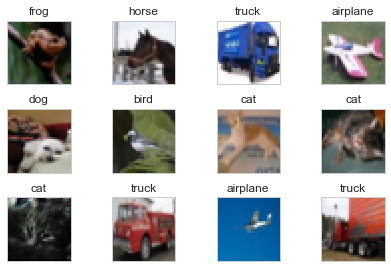

In [6]:
# Visualize sample from training data
fig = plt.figure()

for i in range(12):
  _ = plt.subplot(3, 4, i+1)
  _ = plt.tight_layout()
  _ = plt.imshow(X_train[i], interpolation='none')
  _ = plt.title(classes[y_train[i,0]])
  _ = plt.xticks([])
  _ = plt.yticks([])

### Data preparation

The training, validation, and testing data sets were each transformed into Tensor slices respectively, so that they could be preprocessed before training and evaluation.

The preprocessing steps included centering the data around a mean of zero and standard deviation of 1, shuffling, and subdividing into batches of 32 instances each, as shown in the code below.

In [7]:
# Use Data API to create datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Metal device set to: Apple M1 Pro


2022-05-14 22:33:22.333152: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-14 22:33:22.333813: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
# Create function that standardizes images
def standardize_(image, label):
    """Function that assigns mean=0 and std=1 to
    a given set of images and returns the 
    fully standardized dataset"""
    image = tf.image.per_image_standardization(image)
    return image, label

In [9]:
# Create function that preprocesses images
def preprocess_(input_ds, batch_size=32):
    """Function that standardizes, shuffles, and
    divides a given dataset of images in batches and returns
    the fully processed dataset"""
    ds_size = tf.data.experimental.cardinality(input_ds).numpy()
    processed_ds = (input_ds
                    .map(standardize_)
                    .shuffle(buffer_size=ds_size)
                    .batch(batch_size=batch_size, drop_remainder=True))
    return processed_ds

In [10]:
# Preprocess datasets
train_ds = preprocess_(train_ds)
valid_ds = preprocess_(valid_ds)
test_ds = preprocess_(test_ds)

### Model preparation

The following modifications to the original **AlexNet** architecture were made:

- **Only 3 convolutional layers and 2 dense layers were used**, instead of the original 5 convolutional layers and 3 dense layers, in order to reduce propensity to overfit the comparatively smaller images in the CIFAR10 data set 


- **A batch normalization layer was added after each convolutional layer** to achieve normalization, instead of using the original *local response normalization*, because it was easier to implement and did not reduce overall performance


- **The number of feature maps produced by each convolutional was reduced to a quarter of their original number** (e.g., the first convolutional layer produces only 24 feature maps, instead of 96), which helped reduce both propensity to overfit the data and training time in general


- **The size of the kernels in each layer was reduced** so that the final size of the input images went from 32x32 pixels to 8x8 pixels gradually, thus avoiding dramatic losses of information as much as possible (please refer to architecture summary below for details on specific weights used)


- **A dropout layer was added after the last hidden dense layer**, in order to further add regularization


- Finally, **a 1-cycle learning rate scheduler was used** instead of a fixed learning rate. This scheduler increased the learning rate from 0.001 to a max of 0.05, in order to boost learning halfway through the number of planned epochs


The final results indicated a **test accuracy of 83%**, which is a similar performance to the one reported in the original AlexNet.

In [11]:
# Build model using Functional API
clear_session()

inp_ = Input(shape=X_train.shape[1:])
cv_1 = Conv2D(filters=24, kernel_size=(3,3), \
              strides=(1,1), activation='relu')(inp_)
bn_1 = BatchNormalization()(cv_1)
mx_1 = MaxPool2D(pool_size=(3,3), strides=(1,1))(bn_1)
cv_2 = Conv2D(filters=64, kernel_size=(5,5), \
              strides=(1,1), activation='relu', \
              padding='same')(mx_1)
bn_2 = BatchNormalization()(cv_2)
mx_2 = MaxPool2D(pool_size=(2,2), strides=(2,2))(bn_2)
cv_3 = Conv2D(filters=96, kernel_size=(3,3), \
              strides=(1,1), activation='relu', \
              padding='same')(mx_2)
bn_3 = BatchNormalization()(cv_3)
mx_3 = MaxPool2D(pool_size=(7,7), strides=(1,1))(bn_3)
flat = Flatten()(mx_3)
fc_1 = Dense(1024, activation='relu')(flat)
dr_1 = Dropout(0.5)(fc_1)
out_ = Dense(10, activation='softmax')(dr_1)

model = Model(inputs=[inp_], outputs=[out_])

In [12]:
# Check model architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 24)        672       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 24)       96        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 24)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        38464     
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 64)       256   

In [13]:
# Create class for 1-cycle learning rate scheduler
class OneCycleScheduler(Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        set_value(self.model.optimizer.learning_rate, rate)

In [14]:
# Instantiate scheduler
n_epochs = 20
onecycle = OneCycleScheduler(len(train_ds) * n_epochs, max_rate=0.05)

In [15]:
# Compile model
model.compile(loss='sparse_categorical_crossentropy', \
              optimizer=SGD(learning_rate=1e-3), \
              metrics=['accuracy'])

In [16]:
# Prepare TensorBoard to monitor model training
model_name = 'alexnet_3C_25pW_'
log_dir = "logs/" + model_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

### Model training and evaluation

In [17]:
# Train model
history = model.fit(train_ds, epochs=n_epochs, \
                    validation_data=valid_ds, \
                    callbacks=[tb_callback, \
                               onecycle, \
                               EarlyStopping(patience=3)])

Epoch 1/20


2022-05-14 22:34:16.488253: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-14 22:34:16.488755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1406/1406 [==============================] - ETA: 0s - loss: 1.7484 - accuracy: 0.3988

2022-05-14 22:36:09.599113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1406/1406 [==============================] - 115s 77ms/step - loss: 1.7484 - accuracy: 0.3988 - val_loss: 1.2724 - val_accuracy: 0.5471
Epoch 2/20
1406/1406 [==============================] - 108s 77ms/step - loss: 1.3372 - accuracy: 0.5224 - val_loss: 1.3086 - val_accuracy: 0.5284
Epoch 3/20
1406/1406 [==============================] - 108s 76ms/step - loss: 1.2540 - accuracy: 0.5653 - val_loss: 1.0644 - val_accuracy: 0.6240
Epoch 4/20
1406/1406 [==============================] - 231s 164ms/step - loss: 1.2027 - accuracy: 0.5881 - val_loss: 1.0914 - val_accuracy: 0.6196
Epoch 5/20
1406/1406 [==============================] - 108s 77ms/step - loss: 1.1358 - accuracy: 0.6202 - val_loss: 1.0320 - val_accuracy: 0.6577
Epoch 6/20
1406/1406 [==============================] - 108s 77ms/step - loss: 1.0572 - accuracy: 0.6489 - val_loss: 0.9090 - val_accuracy: 0.6865
Epoch 7/20
1406/1406 [==============================] - 182s 129ms/step - loss: 0.9365 - accuracy: 0.6853 - val_loss: 0.9177 - v

In [18]:
# Visualize results on TensorBoard
%tensorboard --logdir logs

In [19]:
# Evaluate model
test = model.evaluate(test_ds)

312/312 [==============================] - 3s 7ms/step - loss: 0.6238 - accuracy: 0.8231


In [20]:
# Report loss and accuracy of model
history = pd.DataFrame(history.history)

results = pd.DataFrame({
    'source': ['train', 'validation', 'test'], \
    'loss': [history.iloc[-1,0], history.iloc[-1,2], test[0]], \
    'accuracy': [history.iloc[-1,1], history.iloc[-1,3], test[1]] 
})

results

,source,loss,accuracy
0,train,0.115306,0.962149
1,validation,0.551922,0.841346
2,test,0.623786,0.823117
